In [120]:
from jax import numpy as jnp
from jax import random, jit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [301]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
train = pd.read_csv('../datasets/bank-note/train.csv', header=None).to_numpy()
test = pd.read_csv('../datasets/bank-note/test.csv', header=None).to_numpy()
### last column is label (-1,1)

x_train = train[:,:-1]
y_train = train[:,-1:]
y_train = np.where(y_train == 0, -1,1)

x_test = test[:,:-1]
y_test = test[:,-1:]
y_test= np.where(y_test == 0, -1,1)

# add column of ones to wrap in b
x_train = np.concatenate((x_train, np.ones((x_train.shape[0],1))), axis=1)
x_test = np.concatenate((x_test, np.ones((x_test.shape[0],1))), axis=1)

In [312]:
from neural_net import (init_params,
                        model_backprop,
                        model_forward,
                        update_params)

### Homework 2A, getting grads wrt to one example

In [166]:
key = random.PRNGKey(seed=42)
n_h = 2
num_epochs = 100000
print_at = 100
 
X = x_train[0:1]
y = y_train[0:1]

mse = lambda preds,y: 0.5*((y-preds)**2).sum()
params = init_params(key, X.shape[1], n_h, n_y=1)

preds, caches = model_forward(X, params)
grads = model_backprop(preds, y, caches)
print(X, y, grads)

dL_dA2=Array([[1.6273322]], dtype=float32)
[[ 3.8481 10.1539 -3.8561 -4.2228  1.    ]] [[-1]] {'dL_dA1': Array([[0.21711966, 0.15448466]], dtype=float32), 'dL_dW2': Array([[0.10031114, 0.10298899]], dtype=float32), 'dL_db2': Array([[0.19022417]], dtype=float32), 'dL_dA0': Array([[0.01835191, 0.07213192]], dtype=float32), 'dL_dW1': Array([[0.01472927, 0.0008629 ],
       [0.01043946, 0.00061159]], dtype=float32), 'dL_db1': Array([[0.02705886, 0.01917814]], dtype=float32), 'dL_dW0': Array([[ 0.00350323,  0.0092439 , -0.00351051, -0.00384435,  0.00091038],
       [ 0.00171388,  0.00452239, -0.00171745, -0.00188077,  0.00044538]],      dtype=float32), 'dL_db0': Array([[0.00091038, 0.00044538]], dtype=float32)}


### Homework 2B, Learning neural network with SGD + given LR schedule

d=50, init_gamma=0.0005


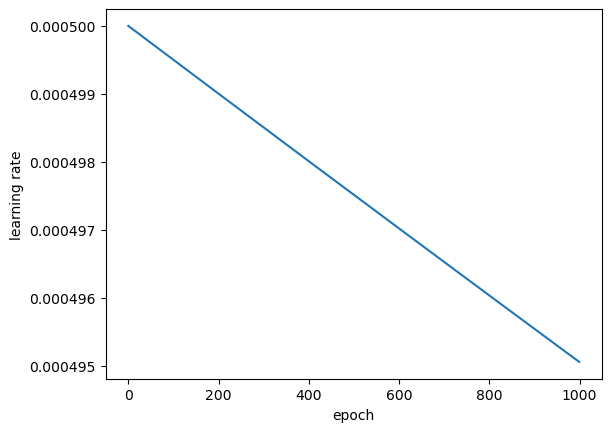

In [314]:
d = 50
init_lr = 0.0005
num_epochs = 1000
lr_sched = lambda  t: init_lr / (1 + (init_lr/d)*t)
plt.plot(np.array([lr_sched(i) for i in range(num_epochs)]))
plt.xlabel('epoch')
plt.ylabel('learning rate')
print(f'{d=}, init_gamma={init_lr}')
plt.savefig('/Users/mattlowery/Desktop/ml/hw/5/lr_schedule')

In [304]:

key = random.PRNGKey(seed=42)
n_h = 2
lr = 0.0001
num_epochs = 1000
print_at = 100
 
X = x_train
y = y_train
mse = lambda preds,y: 0.5*((y-preds)**2).sum()
params = init_params(key, X.shape[1], n_h, n_y=1)
losses = np.zeros((num_epochs,))

@jit
def update(params):
    preds, caches = model_forward(X, params)
    grads = model_backprop(preds, y, caches)
    params = update_params(params, grads, lr)
    return params, preds
### update sgd? just call updatr w/ subset of X/y 

# Loop (gradient descent)
for i in range(num_epochs):
    ### should be able to jit update
    params, preds = update(params)
    loss = mse(preds, y)
    if i % print_at == 0:
        print(loss)
    losses[i] = loss

587.53973
504.86334
474.90506
461.7703
454.75854
450.47424
447.60266
445.54626
443.99902
442.78943


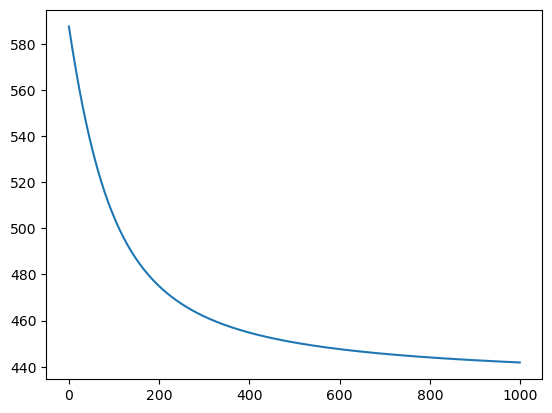

In [305]:
plt.plot(losses)

In [315]:
key = random.PRNGKey(seed=42)
X = x_train
y = y_train
num_epochs = 1000
print_at = 100
mse = lambda preds,y: 0.5*((y-preds)**2).sum()
model_losses = {}
for n_h in [5,10,25,50,100]:
    params = init_params(key, x_train.shape[1], n_h, n_y=1)
    losses = np.zeros((num_epochs))

    @jit
    def update(params,epoch,X,y):
        preds, caches = model_forward(X, params)
        grads = model_backprop(preds, y, caches)
        params = update_params(params, grads, lr=lr_sched(epoch))
        return params, preds
    
    @jit
    def predict(params, x_test):
        preds, caches = model_forward(x_test, params)
        return preds
    print(f'start training model w/ width {n_h=}')
    # consider 1 epoch a full 
    for i in range(num_epochs):
        key,_ = random.split(key)
        ### shuffle
        j = random.choice(key, len(x_train), shape=(len(x_train),))
        X = x_train[j]
        y = y_train[j]

        params, pred = update(params,i,X,y)
        train_loss = mse(pred, y)
        losses[i] = train_loss
        if i % print_at == 0:
            print('epoch', i, f'{train_loss.item()=}')

    test_preds = predict(params, x_test)
    test_acc = (np.round(test_preds) == y_test).mean()
    test_err = mse(test_preds,y_test)
    model_losses[n_h] = (losses, test_err, test_acc)
    






start training model w/ width n_h=5
epoch 0 train_loss.item()=745.2347412109375
epoch 100 train_loss.item()=462.28729248046875
epoch 200 train_loss.item()=441.68927001953125
epoch 300 train_loss.item()=441.40582275390625
epoch 400 train_loss.item()=428.90264892578125
epoch 500 train_loss.item()=425.69818115234375
epoch 600 train_loss.item()=422.85693359375
epoch 700 train_loss.item()=399.9555969238281
epoch 800 train_loss.item()=388.0829162597656
epoch 900 train_loss.item()=370.79754638671875
start training model w/ width n_h=10
epoch 0 train_loss.item()=629.16650390625
epoch 100 train_loss.item()=456.99688720703125
epoch 200 train_loss.item()=433.5541687011719
epoch 300 train_loss.item()=424.97857666015625
epoch 400 train_loss.item()=411.395751953125
epoch 500 train_loss.item()=391.54461669921875
epoch 600 train_loss.item()=364.17578125
epoch 700 train_loss.item()=352.94073486328125
epoch 800 train_loss.item()=331.31390380859375
epoch 900 train_loss.item()=329.5425720214844
start trai

for model width=5, final train loss after 1000 epochs,
 345.58001708984375 
 final_test_loss=201.22503662109375 
          final_test_acc=0.23400001227855682
for model width=10, final train loss after 1000 epochs,
 291.6898193359375 
 final_test_loss=177.183837890625 
          final_test_acc=0.35600000619888306
for model width=25, final train loss after 1000 epochs,
 273.64788818359375 
 final_test_loss=161.13934326171875 
          final_test_acc=0.4140000343322754
for model width=50, final train loss after 1000 epochs,
 337.81011962890625 
 final_test_loss=196.74594116210938 
          final_test_acc=0.21400001645088196
for model width=100, final train loss after 1000 epochs,
 941.9984130859375 
 final_test_loss=557.9674072265625 
          final_test_acc=0.44200003147125244


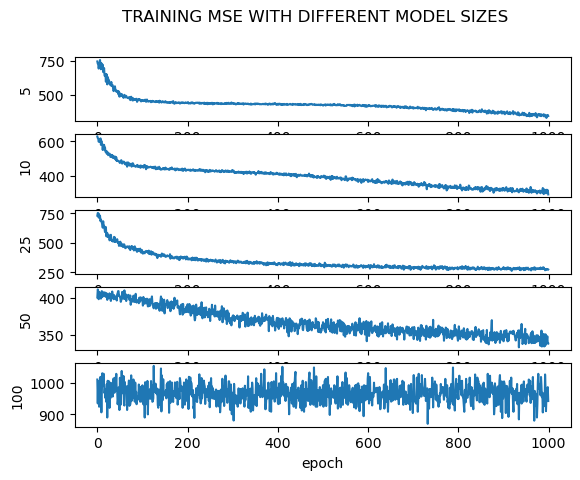

In [316]:
fig, ax = plt.subplots(len(model_losses.keys()))
for i, (width,losses) in enumerate(model_losses.items()):
    train_losses = losses[0]
    final_test_loss = losses[1].item()
    final_test_acc = losses[2].item()
    print(f'for model {width=}, final train loss after {num_epochs} epochs,\n {train_losses[-1].item()} \n {final_test_loss=} \n\
          {final_test_acc=}')
    ax[i].plot(train_losses)
    ax[i].set_ylabel(width)
ax[-1].set_xlabel('epoch')
plt.suptitle('TRAINING MSE WITH DIFFERENT MODEL SIZES')
plt.savefig('/Users/mattlowery/Desktop/ml/hw/5/2B_NN_TRAIN_PLOTS')

### 2C) SAME THING WITH PARAMETERS INITIALITY SET TO 0 VERSUS 




In [309]:
## rewrite init params function for this case
def init_params_zeros(n_x, n_h, n_y):
    # n_x -- num input features
    # n_h -- size of the 2 hidden layers
    # n_y -- size of the output layer
    return {
            "W0": jnp.zeros((n_h,n_x)),
            "b0": jnp.zeros((n_h,)),
            "W1": jnp.zeros((n_h,n_h)),
            "b1": jnp.zeros((n_h,)),
            "W2": jnp.zeros((n_y,n_h)),
            "b2": jnp.zeros((n_y,))
            }


In [310]:
key = random.PRNGKey(seed=42)
X = x_train
y = y_train
num_epochs = 1000
print_at = 100
mse = lambda preds,y: 0.5*((y-preds)**2).sum()
model_losses = {}
for n_h in [5,10,25,50,100]:
    params = init_params_zeros(x_train.shape[1], n_h, n_y=1)
    losses = np.zeros((num_epochs))

    @jit
    def update(params,epoch, X,y):
        preds, caches = model_forward(X, params)
        grads = model_backprop(preds, y, caches)
        params = update_params(params, grads, lr=lr_sched(epoch))
        return params, preds
    
    @jit
    def predict(params, x_test):
        preds, caches = model_forward(x_test, params)
        return preds
    print(f'start training model w/ width {n_h=}')
    # consider 1 epoch a full 
    for i in range(num_epochs):
        key,_ = random.split(key)
        ### shuffle
        j = random.choice(key, len(x_train), shape=(len(x_train),))
        X = x_train[j]
        y = y_train[j]

        params, pred = update(params,i,X,y)
        train_loss = mse(pred, y)
        losses[i] = train_loss
        if i % print_at == 0:
            print('epoch', i, f'{train_loss.item()=}')

    test_preds = predict(params, x_test)
    test_acc = (np.round(test_preds) == y_test).mean()
    test_err = mse(test_preds,y_test)
    model_losses[n_h] = (losses, test_err, test_acc)
    






start training model w/ width n_h=5
epoch 0 train_loss.item()=587.0
epoch 100 train_loss.item()=467.03753662109375
epoch 200 train_loss.item()=450.72015380859375
epoch 300 train_loss.item()=449.7215576171875
epoch 400 train_loss.item()=441.0232849121094
epoch 500 train_loss.item()=440.93328857421875
epoch 600 train_loss.item()=441.53045654296875
epoch 700 train_loss.item()=437.9146728515625
epoch 800 train_loss.item()=438.76654052734375
epoch 900 train_loss.item()=438.23046875
start training model w/ width n_h=10
epoch 0 train_loss.item()=591.0
epoch 100 train_loss.item()=475.4881896972656
epoch 200 train_loss.item()=454.34552001953125
epoch 300 train_loss.item()=449.1435546875
epoch 400 train_loss.item()=444.59747314453125
epoch 500 train_loss.item()=442.2267150878906
epoch 600 train_loss.item()=440.3233947753906
epoch 700 train_loss.item()=441.31060791015625
epoch 800 train_loss.item()=439.535888671875
epoch 900 train_loss.item()=441.31732177734375
start training model w/ width n_h=2

for model width=5, final train loss after 1000 epochs,
 437.93011474609375 
 final_test_loss=251.24252319335938 
          final_test_acc=0.0
for model width=10, final train loss after 1000 epochs,
 437.2325134277344 
 final_test_loss=251.94638061523438 
          final_test_acc=0.0
for model width=25, final train loss after 1000 epochs,
 439.6046447753906 
 final_test_loss=252.8170166015625 
          final_test_acc=0.0
for model width=50, final train loss after 1000 epochs,
 438.2393798828125 
 final_test_loss=253.13226318359375 
          final_test_acc=0.0
for model width=100, final train loss after 1000 epochs,
 440.3174743652344 
 final_test_loss=253.32327270507812 
          final_test_acc=0.0


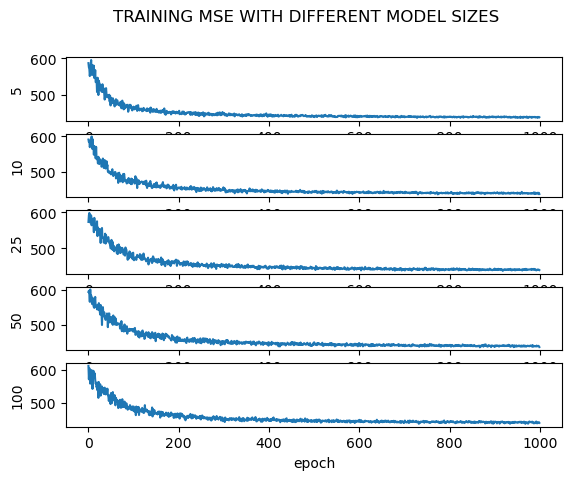

In [311]:
fig, ax = plt.subplots(len(model_losses.keys()))
for i, (width,losses) in enumerate(model_losses.items()):
    train_losses = losses[0]
    final_test_loss = losses[1].item()
    final_test_acc = losses[2].item()
    print(f'for model {width=}, final train loss after {num_epochs} epochs,\n {train_losses[-1].item()} \n {final_test_loss=} \n\
          {final_test_acc=}')
    ax[i].plot(train_losses)
    ax[i].set_ylabel(width)
ax[-1].set_xlabel('epoch')
plt.suptitle('TRAINING MSE WITH DIFFERENT MODEL SIZES')
plt.savefig('/Users/mattlowery/Desktop/ml/hw/5/2C_NN_TRAIN_PLOTS')

#### Paper Problem 3, 

In [159]:
W0 = np.array([[-2,-3],
               [2,3]])
b0 = np.array([[-1,
                1]])
W1 = np.array([[-2,-3],
               [2,3]])
b1 = np.array([[-1,
                1]])
W2 = np.array([[2,-1.5]])
b2 = np.array([[-1]])
 
params = {'W0': W0,
          'b0': b0,
          'W1': W1,
          'b1' : b1,
          'W2' : W2,
          'b2' : b2}

X = np.array([[1,1]])
y = np.array([[1,]])
### using cached model forward? 
preds, caches = model_forward(X, params)
grads = model_backprop(preds, y, caches)
print('final grads')

FORWARD PASS
keeping A prev (X in this case), W0, b0, Z0 for cache
((array([[1, 1]]), array([[-2, -3],
       [ 2,  3]]), array([[-1,  1]])), array([[-6,  6]]))
keep A0, W1, b1, Z1 for cache
((Array([[0.00247262, 0.9975274 ]], dtype=float32), array([[-2, -3],
       [ 2,  3]]), array([[-1,  1]])), Array([[-3.9975276,  3.9975276]], dtype=float32))
keep A1, W2, b2, Z2 for cache
((Array([[0.01802993, 0.9819701 ]], dtype=float32), array([[ 2. , -1.5]]), array([[-1]])), Array([[-2.4368954]], dtype=float32))
preds = [[0.08040217]]
grad of predictions wrt to squared loss = preds - y = [[-0.91959786]]
dL_dZ = dL_dA * 1/(1+jnp.exp(-Z)) * (1-1/(1+jnp.exp(-Z))) = 
[[-0.06799292]]
 dL_dW = (dL_dZ.T @ A_prev) / m =  [[-0.00061295 -0.0333835 ]]
dL_db = dL_dZ.sum(axis=0, keepdims=True) / m =  [[-0.03399646]]
dL_dA_prev = dL_dZ @ W =  [[-0.13598584  0.10198937]]
dL_dZ = dL_dA * 1/(1+jnp.exp(-Z)) * (1-1/(1+jnp.exp(-Z))) = 
[[-0.00240761  0.00180571]]
 dL_dW = (dL_dZ.T @ A_prev) / m =  [[-2.9765547e-06 

In [158]:
from jax import numpy as jnp
from jax import random


def init_params(random_key, n_x, n_h, n_y):
    # n_x -- num input features
    # n_h -- size of the 2 hidden layers
    # n_y -- size of the output layer
    keys = random.split(random_key, 3)
    return {
            "W0": random.uniform(keys[0], shape=(n_h,n_x)),
            "b0": jnp.zeros((n_h,)),
            "W1": random.uniform(keys[1], shape=(n_h,n_h)),
            "b1": jnp.zeros((n_h,)),
            "W2": random.uniform(keys[2], shape=(n_y, n_h)),
            "b2": jnp.zeros((n_y,))
            }

def sigmoid(Z):
    A = 1/(1+jnp.exp(-Z))
    cache = Z ## keep for backprop 
    return A, cache

def sigmoid_backprop(dL_dA, cache):
    Z = cache
    s = 1/(1+jnp.exp(-Z))
    print('dL_dZ = dL_dA * 1/(1+jnp.exp(-Z)) * (1-1/(1+jnp.exp(-Z))) = ')
    dL_dZ = dL_dA * s * (1-s)
    print(dL_dZ)
    return dL_dZ


def layer_forward(A, W, b):
    Z = A @ W.T + b
    linear_cache = (A, W, b) #### keep for backprop
    A, activation_cache = sigmoid(Z)
    cache = (linear_cache, activation_cache)
    return A, cache


def model_forward(X, parameters):
    print('FORWARD PASS')
    A0,cache0 = layer_forward(X, 
                              parameters['W0'], 
                              parameters['b0'])
    print('keeping A prev (X in this case), W0, b0, Z0 for cache')
    print(cache0)

    A1,cache1 = layer_forward(A0, 
                              parameters['W1'], 
                              parameters['b1'])
    print('keep A0, W1, b1, Z1 for cache')
    print(cache1)

    A2, cache2 = layer_forward(A1, 
                              parameters['W2'], 
                              parameters['b2'])
    print('keep A1, W2, b2, Z2 for cache')
    print(cache2)

    caches = (cache0,cache1,cache2)
    print(f'preds = {A2}')

    return A2, caches

def layer_backprop(dL_dA, cache):
    linear_cache, activation_cache = cache
    dL_dZ = sigmoid_backprop(dL_dA, activation_cache)
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    dL_dW = (dL_dZ.T @ A_prev) / m
    print(' dL_dW = (dL_dZ.T @ A_prev) / m = ', dL_dW)
    dL_db = dL_dZ.sum(axis=0, keepdims=True) / m
    print('dL_db = dL_dZ.sum(axis=0, keepdims=True) / m = ', dL_db)
    dL_dA_prev = dL_dZ @ W
    print('dL_dA_prev = dL_dZ @ W = ',dL_dA_prev )
    return dL_dA_prev, dL_dW, dL_db

def model_backprop(preds, y, caches):
    grads = {}
    L = 3
    dL_dA2 = preds - y
    print(f'grad of predictions wrt to squared loss = preds - y = {dL_dA2}')
    print(f'begin output layer backprop (dL_dA2 --> dL_dA1, dL_dW2, dL_db2)')
    dL_dA1, dL_dW2, dL_db2 = layer_backprop(dL_dA2, caches[L-1])
    grads["dL_dA1"] = dL_dA1
    grads["dL_dW2"] = dL_dW2
    grads["dL_db2"] = dL_db2

    print(f'begin output layer backprop (dL_dA1 --> dL_dA0, dL_dW1, dL_db1)')
    dL_dA0, dL_dW1, dL_db1 = layer_backprop(dL_dA1, caches[L-2])
    grads["dL_dA0"] = dL_dA0
    grads["dL_dW1"] = dL_dW1
    grads["dL_db1"] = dL_db1

    print(f'begin output layer backprop (dL_dA0 --> dL_dX, dL_dW0, dL_db0)')
    _, dL_dW0, dL_db0 = layer_backprop(dL_dA0, caches[L-3])
    grads["dL_dW0"] = dL_dW0
    grads["dL_db0"] = dL_db0
    return grads

def update_params(params, grads, lr):
    p = params.copy()
    p['W0'] = p['W0'] - lr * grads['dL_dW0']
    p['b0'] = p['b0'] - lr * grads['dL_db0']
    p['W1'] = p['W1'] - lr * grads['dL_dW1']
    p['b1'] = p['b1'] - lr * grads['dL_db1']     
    p['W2'] = p['W2'] - lr * grads['dL_dW2']
    p['b2'] = p['b2'] - lr * grads['dL_db2']                                                    
                                                  
    return p